<a href="https://colab.research.google.com/github/ryancarneyy/spotify_prediction/blob/main/hierarchical_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will be using hierarchical clusterings to see if we can maybe get groupings that can tell us something about danceability.

In [2]:
import pandas as pd
import numpy as np
from random import sample
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import product
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)


In [3]:
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


First, we must clean the data.

In [4]:
# Check for missing values.
print("Missing values before cleaning:\n", df.isnull().sum())
print("\n")

# Drop rows where critical features like track_id or track_name are missing.
df_cleaned = df.dropna(subset=['track_id', 'track_name'])

# Key is a special feature. If a key cannot be determined, the key is assigned a value of -1.
missing_key_count = (df_cleaned['key'] == -1).sum()
print("Number of songs without a key: ", missing_key_count)

# Fill in missing numerical values with their corresponding feature's mean or median.
df_cleaned.loc[:, 'popularity'] = df_cleaned['popularity'].fillna(df_cleaned['popularity'].mean())
df_cleaned.loc[:, 'danceability'] = df_cleaned['danceability'].fillna(df_cleaned['danceability'].median())
df_cleaned.loc[:, 'energy'] = df_cleaned['energy'].fillna(df_cleaned['energy'].mean())
df_cleaned.loc[:, 'loudness'] = df_cleaned['loudness'].fillna(df_cleaned['loudness'].median())
df_cleaned.loc[:, 'liveness'] = df_cleaned['liveness'].fillna(df_cleaned['liveness'].mean())
df_cleaned.loc[:, 'tempo'] = df_cleaned['tempo'].fillna(df_cleaned['tempo'].mean())

# Fill missing categorical values with their corresponding feature's most common value (mode).
df_cleaned.loc[:, 'track_genre'] = df_cleaned['track_genre'].fillna(df_cleaned['track_genre'].mode()[0])
df_cleaned.loc[:, 'explicit'] = df_cleaned['explicit'].fillna(df_cleaned['explicit'].mode()[0])

# Verify that we have no more missing values.
print("\n\nMissing values after cleaning:\n", df_cleaned.isnull().sum())

Missing values before cleaning:
 Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


Number of songs without a key:  0


Missing values after cleaning:
 Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time

In [5]:
# Remove duplicates based on the track_id column.
df_cleaned = df_cleaned.drop_duplicates(subset=['track_id'])

# Verify that duplicates have been removed.
print("Number of duplicate track_id entries:", df_cleaned.duplicated(subset=['track_id']).sum())


Number of duplicate track_id entries: 0


In [6]:
df_cleaned.select_dtypes('number').describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,89740.000000,89740.000000,8.974000e+04,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000
mean,53479.005739,33.198808,2.291444e+05,0.562166,0.634458,5.283530,-8.498994,0.636973,0.087442,0.328285,0.173415,0.216971,0.469474,122.058134,3.897426
std,33410.141924,20.580640,1.129458e+05,0.176692,0.256606,3.559912,5.221518,0.480875,0.113278,0.338321,0.323849,0.194885,0.262864,30.117651,0.453437
min,0.000000,0.000000,8.586000e+03,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23766.750000,19.000000,1.730400e+05,0.450000,0.457000,2.000000,-10.322250,0.000000,0.036000,0.017100,0.000000,0.098200,0.249000,99.262750,4.000000
50%,50680.500000,33.000000,2.132955e+05,0.576000,0.676000,5.000000,-7.185000,1.000000,0.048900,0.188000,0.000058,0.132000,0.457000,122.013000,4.000000
75%,80618.500000,49.000000,2.642930e+05,0.692000,0.853000,8.000000,-5.108000,1.000000,0.085900,0.625000,0.097625,0.279000,0.682000,140.077000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


We wanted to try and see if using hierarchical clustering could group the data into different clusters that might tell us something about its danceabilility.

In [24]:
hclust = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='ward')

df_sample = df_cleaned.sample(n=1000, random_state=42)
X = df_sample[['valence', 'loudness', 'tempo']]
y = df_sample['danceability']

activity_hclust_labels = hclust.fit(X).labels_

activity_hclust_labels



array([3, 1, 1, 3, 1, 3, 1, 3, 0, 0, 1, 2, 3, 1, 4, 3, 1, 5, 0, 5, 3, 0,
       4, 4, 2, 1, 3, 4, 5, 1, 2, 4, 5, 3, 2, 5, 2, 5, 4, 1, 1, 6, 5, 1,
       3, 3, 1, 4, 4, 1, 2, 0, 3, 2, 1, 3, 5, 1, 1, 3, 3, 1, 0, 1, 5, 3,
       3, 1, 2, 3, 0, 0, 1, 1, 3, 3, 4, 1, 4, 1, 1, 1, 0, 0, 1, 1, 6, 4,
       1, 1, 6, 1, 1, 4, 1, 1, 1, 2, 1, 5, 2, 0, 3, 5, 5, 1, 3, 1, 3, 3,
       2, 1, 1, 6, 1, 1, 2, 1, 0, 3, 3, 6, 3, 5, 1, 1, 3, 5, 4, 1, 5, 3,
       1, 1, 5, 2, 4, 1, 6, 6, 3, 2, 1, 3, 1, 5, 5, 1, 2, 1, 2, 2, 1, 1,
       1, 4, 2, 2, 1, 1, 5, 3, 0, 1, 4, 3, 1, 1, 3, 5, 1, 3, 1, 1, 1, 3,
       0, 6, 1, 3, 6, 3, 3, 3, 6, 1, 5, 3, 1, 1, 1, 6, 2, 1, 5, 3, 1, 2,
       0, 1, 1, 4, 6, 0, 1, 3, 5, 0, 0, 1, 1, 4, 1, 3, 5, 2, 0, 1, 3, 4,
       1, 1, 1, 3, 1, 6, 6, 0, 3, 1, 1, 4, 1, 1, 1, 6, 3, 5, 6, 6, 3, 6,
       1, 1, 1, 2, 6, 6, 5, 2, 1, 2, 2, 3, 2, 3, 5, 1, 3, 2, 0, 3, 0, 1,
       6, 2, 5, 2, 2, 3, 4, 2, 5, 3, 0, 6, 6, 1, 1, 3, 5, 6, 3, 5, 3, 1,
       5, 3, 3, 5, 1, 1, 2, 0, 5, 3, 3, 5, 2, 0, 6,

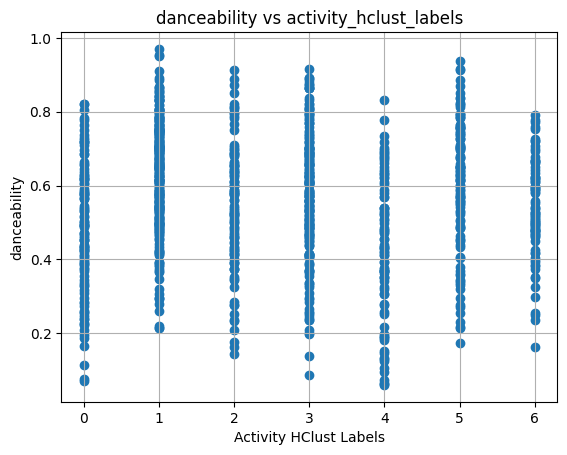

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Plot y vs activity_hclust_labels
plt.scatter(activity_hclust_labels, y)  # Use scatter plot to show discrete labels
plt.title("danceability vs activity_hclust_labels")
plt.xlabel("Activity HClust Labels")
plt.ylabel("danceability")
plt.grid(True)  # Optional: Adds a grid
plt.show()

We tried values all the way from n=2 clusters to n=7 clusters, but it seems that no matter how many clusters we used, each cluster would contain a very diverse set of danceability values, which shows that seperating the data points into clusters doesn't help our mission of predicting danceability.